In [6]:
import numpy as np
import pandas as pd
from utils.model_training import prepare_model_features, visualize_features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier


In [7]:
df = pd.read_csv(
    "./data/processed/stop-and-frisk.csv",
    parse_dates=["STOP_FRISK_DATE"],  
)
# df.info()

In [8]:
X, y = prepare_model_features(df)
assert not X.isnull().any().any(), "Null values remain in features"

In [9]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Train distribution:", y_train.value_counts(normalize=True), "\n")
print("Test distribution:", y_test.value_counts(normalize=True))

Train distribution: OFFICER_USED_FORCE
False    0.748507
True     0.251493
Name: proportion, dtype: float64 

Test distribution: OFFICER_USED_FORCE
False    0.748501
True     0.251499
Name: proportion, dtype: float64


[[4928 3313]
 [1090 1679]]
              precision    recall  f1-score   support

       False       0.82      0.60      0.69      8241
        True       0.34      0.61      0.43      2769

    accuracy                           0.60     11010
   macro avg       0.58      0.60      0.56     11010
weighted avg       0.70      0.60      0.63     11010



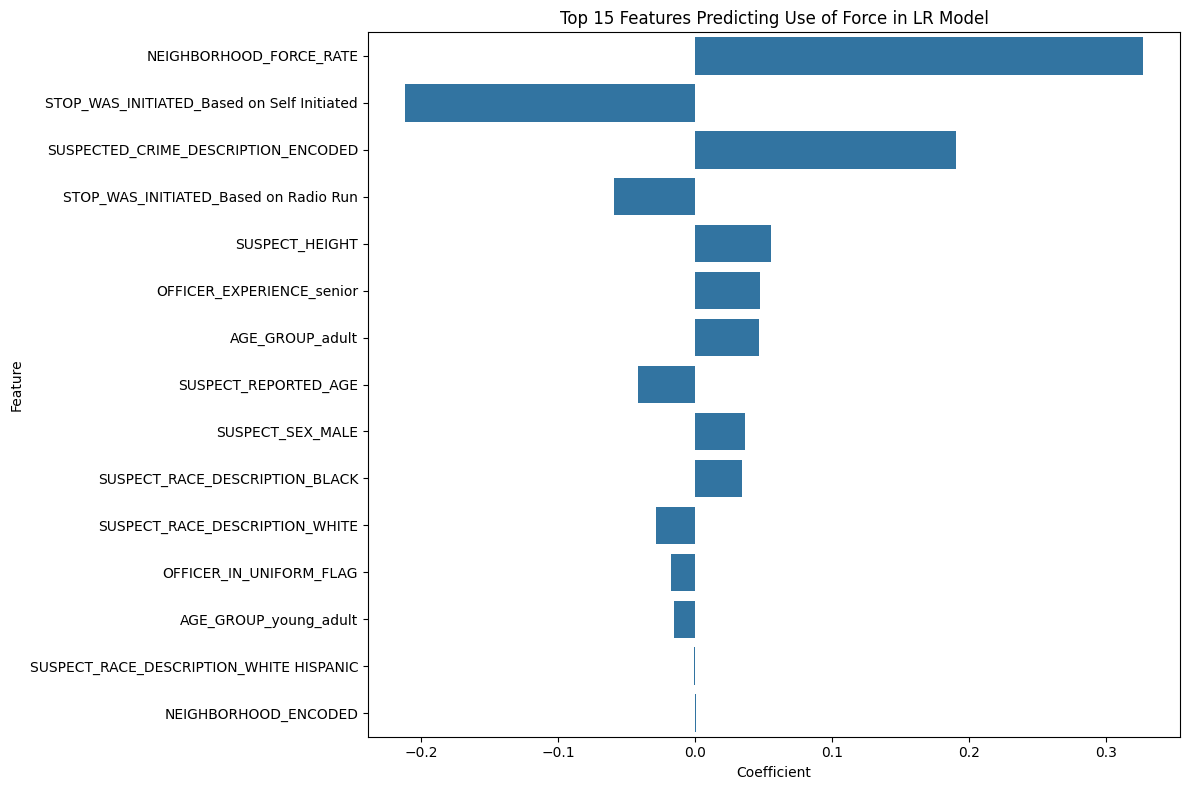

In [16]:
# Standardize features for quicker training...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    C=0.01,
    penalty="l1",
    solver="liblinear",
    random_state=42,
)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
visualize_features(X, lr_model, "Top 15 Features Predicting Use of Force in LR Model")

In [12]:
# Temp
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=5,           # Increase regularization
    depth=5,
    loss_function='Logloss',
    eval_metric='AUC',
    scale_pos_weight=7,  # Balances positive class
    verbose=0,
    random_seed=42,
    # eval_metric='F1',        # Monitor F1 during training
    # use_best_model=True,     # Use best model by validation set
    # early_stopping_rounds=50,
    # verbose=100
)


cat_model.fit(X_train, y_train)
y_proba = cat_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Get feature importances and names
feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns

# Sort features by importance (descending)
sorted_idx = np.argsort(feature_importances)[::-1]  # [::-1] reverses for descending
sorted_features = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

print("Top Features:")
for feat, imp in zip(sorted_features, sorted_importances):
    print(f"{feat}: {imp:.4f}")

[[1600 6641]
 [ 148 2621]]
              precision    recall  f1-score   support

       False       0.92      0.19      0.32      8241
        True       0.28      0.95      0.44      2769

    accuracy                           0.38     11010
   macro avg       0.60      0.57      0.38     11010
weighted avg       0.76      0.38      0.35     11010

Top Features:
SUSPECTED_CRIME_DESCRIPTION_ENCODED: 14.0648
SUSPECT_REPORTED_AGE: 13.4327
NEIGHBORHOOD_ENCODED: 10.7500
HOUR_OF_DAY: 10.2361
NEIGHBORHOOD_FORCE_RATE: 10.0254
STOP_WAS_INITIATED_Based on Self Initiated: 8.8743
SUSPECT_HEIGHT: 6.2890
OFFICER_EXPERIENCE_senior: 3.6205
STOP_WAS_INITIATED_Based on Radio Run: 2.7670
BOROUGH_FORCE_RATE: 2.7530
STOP_LOCATION_BORO_NAME_ENCODED: 2.3943
SUSPECT_SEX_MALE: 1.7550
SUSPECT_RACE_DESCRIPTION_BLACK: 1.6520
AGE_GROUP_young_adult: 1.5304
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 1.4318
OFFICER_IN_UNIFORM_FLAG: 1.3003
SUSPECT_RACE_DESCRIPTION_WHITE: 1.1234
AGE_GROUP_adult: 1.0036
IS_WEEKEND: 0.9

In [15]:
len(feature_importances), len(X.columns), sorted_features

(26,
 26,
 Index(['SUSPECTED_CRIME_DESCRIPTION_ENCODED', 'SUSPECT_REPORTED_AGE',
        'NEIGHBORHOOD_ENCODED', 'HOUR_OF_DAY', 'NEIGHBORHOOD_FORCE_RATE',
        'STOP_WAS_INITIATED_Based on Self Initiated', 'SUSPECT_HEIGHT',
        'OFFICER_EXPERIENCE_senior', 'STOP_WAS_INITIATED_Based on Radio Run',
        'BOROUGH_FORCE_RATE', 'STOP_LOCATION_BORO_NAME_ENCODED',
        'SUSPECT_SEX_MALE', 'SUSPECT_RACE_DESCRIPTION_BLACK',
        'AGE_GROUP_young_adult', 'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC',
        'OFFICER_IN_UNIFORM_FLAG', 'SUSPECT_RACE_DESCRIPTION_WHITE',
        'AGE_GROUP_adult', 'IS_WEEKEND', 'AGE_GROUP_teen', 'IS_CHILD',
        'SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER',
        'SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC',
        'SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN',
        'AGE_GROUP_senior', 'IS_NIGHT'],
       dtype='object'))